In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, classification_report
from xgboost import XGBClassifier 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold


In [2]:
df = pd.read_csv('nba_engineered_game_df.csv')
df = df.sort_values(by=['date']).reset_index(drop=True)
pd.set_option('display.max_columns', None)
df.head(6)

,Team_A,Team_B,matchup_id,date,Team_A_+/-_basic_max,Team_A_AST_basic_totals,Team_A_DRtg_advanced_max,Team_A_DRtg_advanced_totals,Team_A_FG%_basic_totals,Team_A_FG_basic_max,Team_A_FG_basic_totals,Team_A_GmSc_basic_max,Team_A_ORtg_advanced_totals,Team_A_PTS_basic_max,Team_A_PTS_basic_totals,Team_A_Q1,Team_A_Q3,Team_A_TRB%_advanced_totals,Team_A_TS%_advanced_totals,Team_A_eFG%_advanced_totals,Team_B_+/-_basic_max,Team_B_3PAr_advanced_max,Team_B_BLK_basic_totals,Team_B_DRB_basic_totals,Team_B_DRtg_advanced_max,Team_B_DRtg_advanced_totals,Team_B_FG%_basic_totals,Team_B_FG_basic_totals,Team_B_GmSc_basic_max,Team_B_ORtg_advanced_totals,Team_B_PTS_basic_totals,Team_B_Q1,Team_B_TRB_basic_totals,Team_B_TS%_advanced_totals,Team_B_eFG%_advanced_totals,Team_A_win,Team_A_home,Team_A_win_next,playoff_game,next_matchup_date,Team_A_win_last5,Team_A_+/-_basic_max_last5,Team_A_3P%_basic_totals_last5,Team_A_3PAr_advanced_max_last5,Team_A_3P_basic_max_last5,Team_A_3P_basic_totals_last5,Team_A_AST_basic_max_last5,Team_A_AST_basic_totals_last5,Team_A_BLK%_advanced_totals_last5,Team_A_BLK_basic_totals_last5,Team_A_DRtg_advanced_max_last5,Team_A_DRtg_advanced_totals_last5,Team_A_FG%_basic_max_last5,Team_A_FG%_basic_totals_last5,Team_A_FGA_basic_max_last5,Team_A_FG_basic_max_last5,Team_A_FG_basic_totals_last5,Team_A_FTA_basic_max_last5,Team_A_FT_basic_max_last5,Team_A_GmSc_basic_max_last5,Team_A_ORtg_advanced_max_last5,Team_A_ORtg_advanced_totals_last5,Team_A_PTS_basic_max_last5,Team_A_PTS_basic_totals_last5,Team_A_Q1_last5,Team_A_Q2_last5,Team_A_Q3_last5,Team_A_TRB%_advanced_totals_last5,Team_A_TS%_advanced_max_last5,Team_A_TS%_advanced_totals_last5,Team_A_USG%_advanced_max_last5,Team_A_eFG%_advanced_max_last5,Team_A_eFG%_advanced_totals_last5,Team_B_win_last5,Team_B_+/-_basic_max_last5,Team_B_3P%_basic_totals_last5,Team_B_3PAr_advanced_max_last5,Team_B_DRB%_advanced_totals_last5,Team_B_DRB_basic_totals_last5,Team_B_DRtg_advanced_max_last5,Team_B_DRtg_advanced_totals_last5,Team_B_FG%_basic_max_last5,Team_B_FG%_basic_totals_last5,Team_B_FG_basic_max_last5,Team_B_FG_basic_totals_last5,Team_B_FTA_basic_max_last5,Team_B_FT_basic_max_last5,Team_B_GmSc_basic_max_last5,Team_B_ORtg_advanced_max_last5,Team_B_ORtg_advanced_totals_last5,Team_B_PTS_basic_max_last5,Team_B_PTS_basic_totals_last5,Team_B_Q1_last5,Team_B_Q3_last5,Team_B_TRB%_advanced_totals_last5,Team_B_TS%_advanced_max_last5,Team_B_TS%_advanced_totals_last5,Team_B_USG%_advanced_max_last5,Team_B_eFG%_advanced_max_last5,Team_B_eFG%_advanced_totals_last5,Team_A_Elo_after_current_game,Team_B_Elo_after_current_game,Team_A_Elo_before_next_matchup,Team_B_Elo_before_next_matchup,elo_diff_before_next_matchup,Elo_diff_after_current_game
0,12,13,LAC_vs_LAL,2009-10-27,14.0,27.0,110.0,101.6,0.448,8.0,39.0,15.1,94.4,21.0,92.0,22,26,52.0,0.489,0.466,14.0,0.500,4.0,30.0,102.0,94.4,0.412,35.0,26.8,101.6,99.0,32,47.0,0.489,0.435,0,0,1.0,0,2010-01-06,0.6,10.6,0.4402,0.5678,3.0,6.6,9.6,24.8,9.08,6.0,119.2,109.88,0.8460,0.5052,18.0,10.6,38.2,7.4,6.0,20.70,164.6,108.72,24.0,98.6,22.8,25.8,27.0,50.24,0.8644,0.5796,34.92,0.8834,0.5494,0.8,17.0,0.3800,0.7834,79.42,32.6,115.6,108.58,0.7700,0.4922,11.6,41.8,9.2,7.6,26.84,170.0,116.30,33.0,111.0,25.4,29.8,53.76,0.8114,0.5806,31.70,0.8082,0.5368,1499.392503,1510.607497,1467.767378,1631.558046,-163.790668,-11.214994
1,6,29,DAL_vs_WAS,2009-10-27,7.0,16.0,123.0,113.3,0.395,10.0,30.0,21.5,101.1,34.0,91.0,21,24,47.7,0.500,0.421,16.0,0.750,4.0,37.0,112.0,101.1,0.464,39.0,20.6,113.3,102.0,21,46.0,0.539,0.488,0,1,1.0,0,2010-01-20,0.4,5.4,0.3808,0.7220,2.8,5.8,11.2,23.0,8.28,5.4,121.4,114.32,0.7534,0.4608,19.8,10.4,35.0,9.8,8.8,21.44,145.2,106.28,29.4,94.8,20.8,22.2,27.0,48.50,0.9532,0.5448,45.14,0.9080,0.4978,0.4,8.6,0.3598,0.7250,68.72,30.4,119.0,110.58,0.7758,0.4482,9.6,36.4,8.8,7.0,21.74,154.0,108.66,27.4,96.8,22.0,26.6,48.60,0.8982,0.5268,28.62,0.8934,0.4806,1491.948168,1518.051832,1577.668869,1436.170763,141.498106,-26.103665
2,10,24,HOU_vs_POR,2009-10-27,8.0,18.0,111.0,99.4,0.370

In [3]:
df = df.drop(columns=['date', 'next_matchup_date', 'matchup_id'])
train_size = int(0.7 * len(df))  
val_size = int(0.15 * len(df))   
test_size = len(df) - train_size - val_size  

y = df['Team_A_win_next']
df = df.drop(columns=['Team_A_win_next'])
x_train = df.iloc[:train_size]
x_val = df.iloc[train_size:train_size+val_size]
x_test = df.iloc[train_size+val_size:]
y_train = y.iloc[:train_size]
y_train = y_train.to_numpy().reshape(-1,1)
y_val = y.iloc[train_size:train_size+val_size]
y_val = y_val.to_numpy().reshape(-1,1)
y_test = y.iloc[train_size+val_size:]
y_test = y_test.to_numpy().reshape(-1,1)
x_train.shape

(13108, 102)

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [5]:
all_columns = df.columns.tolist()
binary_cols = [col for col in x_train.columns if x_train[col].nunique() == 2]
exclude_cols = set(binary_cols + ['Team_A', 'Team_B'])
normalize_cols = [col for col in all_columns if col not in exclude_cols]
normalize_indices = [all_columns.index(col) for col in normalize_cols]

mean = x_train[normalize_cols].mean().values
std = x_train[normalize_cols].std().values
x_train = x_train.to_numpy()
x_val = x_val.to_numpy()
x_test = x_test.to_numpy()

x_train[:, normalize_indices] = (x_train[:, normalize_indices] - mean) / std
x_val[:, normalize_indices] = (x_val[:, normalize_indices] - mean) / std
x_test[:, normalize_indices] = (x_test[:, normalize_indices] - mean) / std

In [6]:
num_features = x_train.shape[1]
w = np.random.normal(0, 0.01, size=(num_features, 1))
b = 0
#z = x_train @ w + b
#y_pred = sigmoid(z)

In [7]:
def compute_cost(x, y, w, b):
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    loss = - (1/m) * (y.T @ np.log(y_pred) + (1 - y).T @ np.log(1 - y_pred))
    return loss.item()

In [8]:
def compute_gradients(x, y, w, b): 
    m = y.shape[0]
    z = x @ w + b
    y_pred = sigmoid(z)
    dj_dw = (1/m) * x.T @ (y_pred - y) 
    dj_db = (1/m) * np.sum(y_pred - y)
    return dj_dw, dj_db

In [9]:
learning_rate = 0.01
num_epochs = 100
train_cost_history = []
val_cost_history = []

for epoch in range(num_epochs):
    dj_dw, dj_db = compute_gradients(x_train, y_train, w, b)
    
    #print(f"Epoch {epoch+1}")
    #print(f"  Mean dj_dw: {np.mean(dj_dw):.6f}, dj_db: {dj_db:.6f}")
    #print(f"  Mean weight before update: {np.mean(w):.6f}")

    w = w - (learning_rate * dj_dw)
    b = b - (learning_rate * dj_db)
    
    #print(f"  Mean weight after update: {np.mean(w):.6f}")
    #print(f"  Training Cost: {train_cost:.6f}, Validation Cost: {val_cost:.6f}")
    
    train_cost = compute_cost(x_train, y_train, w, b)
    train_cost_history.append(train_cost) 
    val_cost = compute_cost(x_val, y_val, w, b)
    val_cost_history.append(val_cost) 
    print(f"Epoch {epoch+1}/{num_epochs}, Training Cost: {train_cost:.4f}, Validation Cost: {val_cost:.4f}")


Epoch 1/100, Training Cost: 0.6966, Validation Cost: 0.7010
Epoch 2/100, Training Cost: 0.6910, Validation Cost: 0.6911
Epoch 3/100, Training Cost: 0.6880, Validation Cost: 0.6902
Epoch 4/100, Training Cost: 0.6855, Validation Cost: 0.6876
Epoch 5/100, Training Cost: 0.6831, Validation Cost: 0.6858
Epoch 6/100, Training Cost: 0.6808, Validation Cost: 0.6840
Epoch 7/100, Training Cost: 0.6787, Validation Cost: 0.6823
Epoch 8/100, Training Cost: 0.6767, Validation Cost: 0.6808
Epoch 9/100, Training Cost: 0.6748, Validation Cost: 0.6793
Epoch 10/100, Training Cost: 0.6730, Validation Cost: 0.6779
Epoch 11/100, Training Cost: 0.6713, Validation Cost: 0.6766
Epoch 12/100, Training Cost: 0.6697, Validation Cost: 0.6754
Epoch 13/100, Training Cost: 0.6682, Validation Cost: 0.6743
Epoch 14/100, Training Cost: 0.6668, Validation Cost: 0.6732
Epoch 15/100, Training Cost: 0.6654, Validation Cost: 0.6722
Epoch 16/100, Training Cost: 0.6642, Validation Cost: 0.6712
Epoch 17/100, Training Cost: 0.66

In [10]:
z_val = x_val @ w + b
y_val_probs = sigmoid(z_val)
y_val_pred = (y_val_probs >= 0.5).astype(int)
accuracy = np.mean(y_val_pred == y_val)
print(f"Validation Accuracy: {accuracy * 100:.3f}%")

Validation Accuracy: 61.610%


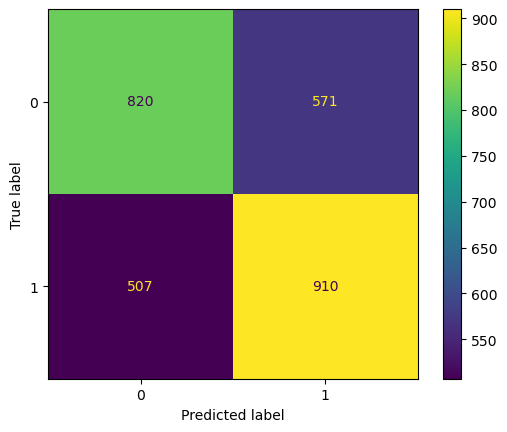

In [11]:
conf_matrix = confusion_matrix(y_val, y_val_pred)
conf_matrix_display = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
conf_matrix_display.plot()

In [12]:
tn, fp, fn, tp = conf_matrix.ravel()

tpr = tp / (tp + fn)  
fpr = fp / (fp + tn)  
tnr = tn / (tn + fp)  
fnr = fn / (fn + tp)  
print(f"TPR: {tpr:.4f}")
print(f"FPR: {fpr:.3f}")
print(f"TNR: {tnr:.3f}")
print(f"FNR: {fnr:.3f}")
probs = sigmoid(x_val @ w + b)
auc = roc_auc_score(y_val, probs)
print("AUC:", auc)

TPR: 0.6422
FPR: 0.410
TNR: 0.590
FNR: 0.358
AUC: 0.6591111221599485


In [42]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Try different hyperparameter combinations manually
print("Testing different XGBoost configurations...")
print("="*60)

# Configuration 1: Original
config1 = XGBClassifier(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42,
    eval_metric='logloss'
)

# Configuration 2: More trees, lower learning rate
config2 = XGBClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=8,
    min_child_weight=3,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Configuration 3: Regularized model
config3 = XGBClassifier(
    n_estimators=400,
    learning_rate=0.1,
    max_depth=5,
    min_child_weight=5,
    subsample=0.7,
    colsample_bytree=0.7,
    reg_alpha=0.1,
    reg_lambda=1.0,
    random_state=42,
    eval_metric='logloss'
)

# Configuration 4: Deeper trees
config4 = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=10,
    min_child_weight=1,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42,
    eval_metric='logloss'
)

configs = {
    'Original': config1,
    'More Trees + Lower LR': config2,
    'Regularized': config3,
    'Deeper Trees': config4
}

results = {}

for name, model in configs.items():
    print(f"\nTraining {name}...")
    
    # Train with early stopping
    model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        verbose=False
    )
    
    # Validate
    val_pred = model.predict(x_val)
    val_pred_proba = model.predict_proba(x_val)[:, 1]
    val_acc = accuracy_score(y_val, val_pred)
    val_auc = roc_auc_score(y_val, val_pred_proba)
    
    # Test
    test_pred = model.predict(x_test)
    test_pred_proba = model.predict_proba(x_test)[:, 1]
    test_acc = accuracy_score(y_test, test_pred)
    test_auc = roc_auc_score(y_test, test_pred_proba)
    
    results[name] = {
        'val_acc': val_acc,
        'val_auc': val_auc,
        'test_acc': test_acc,
        'test_auc': test_auc,
        'model': model
    }
    
    print(f"  Validation - Acc: {val_acc:.4f}, AUC: {val_auc:.4f}")
    print(f"  Test - Acc: {test_acc:.4f}, AUC: {test_auc:.4f}")

# 2. Results comparison
print(f"\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
print(f"{'Model':<20} {'Val Acc':<10} {'Val AUC':<10} {'Test Acc':<10} {'Test AUC':<10}")
print("-" * 60)

best_model_name = None
best_auc = 0

for name, result in results.items():
    print(f"{name:<20} {result['val_acc']:<10.4f} {result['val_auc']:<10.4f} {result['test_acc']:<10.4f} {result['test_auc']:<10.4f}")
    if result['test_auc'] > best_auc:
        best_auc = result['test_auc']
        best_model_name = name

print(f"\nBest model: {best_model_name} (Test AUC: {best_auc:.4f})")
best_model = results[best_model_name]['model']

# 3. Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': x_train.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Most Important Features ({best_model_name}):")
print(feature_importance.head(10))

# 4. Visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Feature importance plot
top_features = feature_importance.head(15)
axes[0, 0].barh(range(len(top_features)), top_features['importance'])
axes[0, 0].set_yticks(range(len(top_features)))
axes[0, 0].set_yticklabels(top_features['feature'])
axes[0, 0].set_xlabel('Feature Importance')
axes[0, 0].set_title(f'Top 15 Features - {best_model_name}')
axes[0, 0].invert_yaxis()

# Model comparison - AUC
model_names = list(results.keys())
test_aucs = [results[name]['test_auc'] for name in model_names]
axes[0, 1].bar(model_names, test_aucs)
axes[0, 1].set_ylabel('Test AUC')
axes[0, 1].set_title('Model Comparison - Test AUC')
axes[0, 1].tick_params(axis='x', rotation=45)

# Confusion matrix for best model
best_test_pred = best_model.predict(x_test)
cm = confusion_matrix(y_test, best_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Loss', 'Win'], yticklabels=['Loss', 'Win'])
axes[1, 0].set_title(f'Confusion Matrix - {best_model_name}')
axes[1, 0].set_ylabel('Actual')
axes[1, 0].set_xlabel('Predicted')

# Prediction probability distribution
best_test_proba = best_model.predict_proba(x_test)[:, 1]
axes[1, 1].hist(best_test_proba[y_test == 0], alpha=0.7, label='Loss', bins=30)
axes[1, 1].hist(best_test_proba[y_test == 1], alpha=0.7, label='Win', bins=30)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_title('Prediction Probability Distribution')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# 5. Class balance check
print(f"\n" + "="*60)
print("DATA ANALYSIS")
print("="*60)
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set class distribution:")
print(y_test.value_counts(normalize=True))

# 6. Try with class weight balancing if imbalanced
class_counts = y_train.value_counts()
if min(class_counts) / max(class_counts) < 0.4:  # If classes are imbalanced
    print(f"\nDetected class imbalance. Testing balanced model...")
    
    scale_pos_weight = class_counts[0] / class_counts[1]
    
    balanced_model = XGBClassifier(
        n_estimators=400,
        learning_rate=0.1,
        max_depth=6,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric='logloss'
    )
    
    balanced_model.fit(
        x_train, y_train,
        eval_set=[(x_val, y_val)],
        early_stopping_rounds=50,
        verbose=False
    )
    
    bal_test_pred = balanced_model.predict(x_test)
    bal_test_proba = balanced_model.predict_proba(x_test)[:, 1]
    bal_test_acc = accuracy_score(y_test, bal_test_pred)
    bal_test_auc = roc_auc_score(y_test, bal_test_proba)
    
    print(f"Balanced model - Test Acc: {bal_test_acc:.4f}, Test AUC: {bal_test_auc:.4f}")
    
    if bal_test_auc > best_auc:
        print("Balanced model performs better!")
        best_model = balanced_model
        best_model_name = "Balanced Model"
        best_auc = bal_test_auc

# 7. Final recommendations
print(f"\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

improvement = best_auc - 0.6623  # Original test AUC
print(f"Best model improvement: +{improvement:.4f} AUC points")

if best_auc < 0.75:
    print(f"\nSuggestions for further improvement:")
    print(f"1. Feature engineering - create interaction terms between top features")
    print(f"2. Try ensemble methods (combining multiple models)")
    print(f"3. Consider other algorithms (CatBoost, LightGBM)")
    print(f"4. Collect more training data if possible")
    print(f"5. Feature selection - remove noisy features")
    print(f"6. Check for data leakage in features")

# 8. Save best model results
final_results = pd.DataFrame({
    'actual': y_test,
    'predicted': best_model.predict(x_test),
    'probability': best_model.predict_proba(x_test)[:, 1]
})

print(f"\nSample predictions from best model ({best_model_name}):")
print(final_results.head(10))

Testing different XGBoost configurations...

Training Original...
  Validation - Acc: 0.6061, AUC: 0.6425
  Test - Acc: 0.6117, AUC: 0.6623

Training More Trees + Lower LR...
  Validation - Acc: 0.6161, AUC: 0.6537
  Test - Acc: 0.6189, AUC: 0.6641

Training Regularized...
  Validation - Acc: 0.6197, AUC: 0.6486
  Test - Acc: 0.6093, AUC: 0.6542

Training Deeper Trees...
  Validation - Acc: 0.6140, AUC: 0.6472
  Test - Acc: 0.6135, AUC: 0.6587

RESULTS SUMMARY
Model                Val Acc    Val AUC    Test Acc   Test AUC  
------------------------------------------------------------
Original             0.6061     0.6425     0.6117     0.6623    
More Trees + Lower LR 0.6161     0.6537     0.6189     0.6641    
Regularized          0.6197     0.6486     0.6093     0.6542    
Deeper Trees         0.6140     0.6472     0.6135     0.6587    

Best model: More Trees + Lower LR (Test AUC: 0.6641)


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

XGBOOST MODEL COMPARISON

Training XGB_1...

Training XGB_2...

Training XGB_3...

Ensembling...

MODEL PERFORMANCE COMPARISON
------------------------------------------------------------
Model           Val Acc    Val AUC    Test Acc   Test AUC  
------------------------------------------------------------
XGB_1           0.6207     0.6575     0.6139     0.6567    
XGB_2           0.6150     0.6495     0.6128     0.6562    
XGB_3           0.6115     0.6537     0.6174     0.6636    
XGB_Ensemble    0.6211     0.6588     0.6224     0.6649    


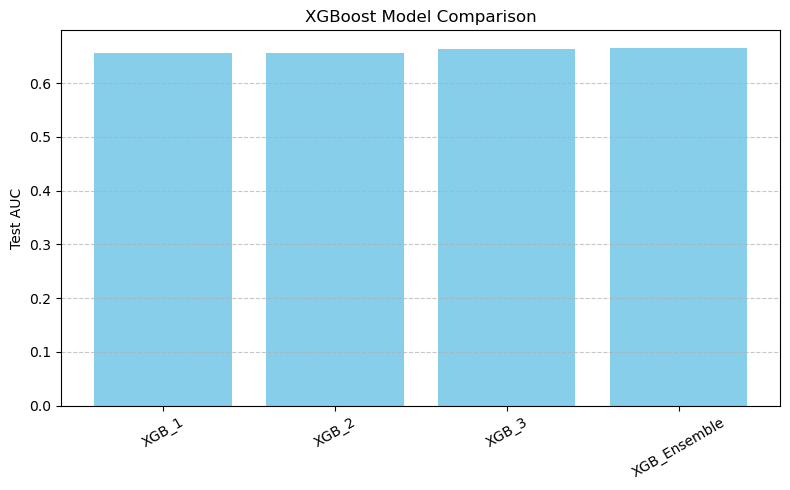

In [44]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt

print("XGBOOST MODEL COMPARISON")
print("="*60)

# Optional: scale data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_val_scaled = scaler.transform(x_val)
x_test_scaled = scaler.transform(x_test)

# Define different XGBoost configurations
configs = {
    'XGB_1': XGBClassifier(n_estimators=300, learning_rate=0.1, max_depth=4, eval_metric='logloss', random_state=42),
    'XGB_2': XGBClassifier(n_estimators=500, learning_rate=0.05, max_depth=6, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42),
    'XGB_3': XGBClassifier(n_estimators=400, learning_rate=0.03, max_depth=8, min_child_weight=3, subsample=0.8, colsample_bytree=0.8, eval_metric='logloss', random_state=42),
}

results = {}
probas_val = []
probas_test = []

# Train and evaluate each model
for name, model in configs.items():
    print(f"\nTraining {name}...")
    model.fit(x_train, y_train)

    val_pred = model.predict(x_val)
    val_proba = model.predict_proba(x_val)[:, 1]
    test_pred = model.predict(x_test)
    test_proba = model.predict_proba(x_test)[:, 1]

    acc_val = accuracy_score(y_val, val_pred)
    auc_val = roc_auc_score(y_val, val_proba)
    acc_test = accuracy_score(y_test, test_pred)
    auc_test = roc_auc_score(y_test, test_proba)

    results[name] = {
        'val_acc': acc_val,
        'val_auc': auc_val,
        'test_acc': acc_test,
        'test_auc': auc_test
    }

    probas_val.append(val_proba)
    probas_test.append(test_proba)

# Ensemble by averaging
print("\nEnsembling...")
ensemble_val_proba = np.mean(probas_val, axis=0)
ensemble_test_proba = np.mean(probas_test, axis=0)
ensemble_val_pred = (ensemble_val_proba > 0.5).astype(int)
ensemble_test_pred = (ensemble_test_proba > 0.5).astype(int)

results['XGB_Ensemble'] = {
    'val_acc': accuracy_score(y_val, ensemble_val_pred),
    'val_auc': roc_auc_score(y_val, ensemble_val_proba),
    'test_acc': accuracy_score(y_test, ensemble_test_pred),
    'test_auc': roc_auc_score(y_test, ensemble_test_proba)
}

# Print comparison
print("\nMODEL PERFORMANCE COMPARISON")
print("-" * 60)
print(f"{'Model':<15} {'Val Acc':<10} {'Val AUC':<10} {'Test Acc':<10} {'Test AUC':<10}")
print("-" * 60)
for name, metrics in results.items():
    print(f"{name:<15} {metrics['val_acc']:<10.4f} {metrics['val_auc']:<10.4f} {metrics['test_acc']:<10.4f} {metrics['test_auc']:<10.4f}")

# Plot AUCs
plt.figure(figsize=(8, 5))
model_names = list(results.keys())
test_aucs = [results[name]['test_auc'] for name in model_names]
plt.bar(model_names, test_aucs, color='skyblue')
plt.ylabel('Test AUC')
plt.title('XGBoost Model Comparison')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
